<a href="https://colab.research.google.com/github/2025-01-sookmyung-opensource/final_project/blob/pre-yoon/final_03(%EC%8B%A4%EC%A0%9C_%EB%8D%B0%EC%9D%B4%ED%84%B0_20%EC%A2%85_%26_yolov11).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

to. 우진 : [1]에 api 키만 넣고 실행시키시면 됩니다!  

In [ ]:
# Roboflow 에서 데이터셋 가져오기 (20종) -> api key 는 마스킹
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="9C")
project = rf.workspace("yoon-pvmwt").project("opensource_final_yoon")
version = project.version(1)
dataset = version.download("yolov8")

Train 이미지 개수: 1680
첫 5개 파일명: ['whitepeach_098_jpg.rf.9295d5ec063e6d8adf39221856cd574b.jpg', 'baguette_041_jpg.rf.ea25a22f72959b977aae23bb27fd3dc9.jpg', 'whitepeach_094_jpg.rf.55e2a2cf9ef91bf055cde54443140eb7.jpg', 'vanillaicecream_096_jpg.rf.9946ae2d9763c7e42a05ed1f73b81c37.jpg', 'whitepeach_030_jpg.rf.804baa5a6539128ce5bfcf9e96db2310.jpg']


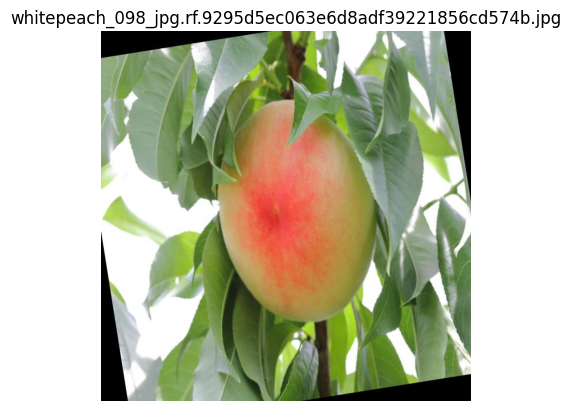

In [2]:
# 데이터셋 내부 train 이미지 확인
import os
from PIL import Image
import matplotlib.pyplot as plt

image_dir = os.path.join(dataset.location, "train", "images")
image_files = os.listdir(image_dir)

print(f"Train 이미지 개수: {len(image_files)}")
print(f"첫 5개 파일명: {image_files[:5]}")

# 첫번째 이미지 시각화
img_path = os.path.join(image_dir, image_files[0])
img = Image.open(img_path)
plt.imshow(img)
plt.title(image_files[0])
plt.axis('off')
plt.show()

In [14]:
# 현재는 김치찌개, 비빔밥이 미포함된 상태 (총 18/20)

data_yaml = """
train: /content/opensource_final_yoon-1/train/images
val: /content/opensource_final_yoon-1/valid/images

nc: 18
names:
  - steamedrice
  - japchae
  - eeldonburi
  - jjajangmyeon
  - tunasandwich
  - chickensteak
  - coldsoymilknoodles
  - pasta
  - grilledribs
  - bakedpotato
  - crabstick
  - marinatedcrab
  - grilledmackerel
  - noodles
  - roastedsweetpotato
  - mungbeansprouts
  - scrambledegg
  - spinach
"""

with open("data.yaml", "w") as f:
    f.write(data_yaml)

print("data.yaml 생성 완료!")

data.yaml 생성 완료!


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # pretrained 모델 로드

model.train(
    data='data.yaml',
    epochs=100,
    batch=16,
    imgsz=640,
    augment=True,
    project='runs/train',
    name='yolov8n_food',
)

특이사항 : yolov8 을 다운받으려 했으나 자동으로 11버전이 다운됨. 아래 로그 참고

AMP: running Automatic Mixed Precision (AMP) checks...
Downloading https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11n.pt to 'yolo11n.pt'...
100%|██████████| 5.35M/5.35M [00:00<00:00, 152MB/s]

In [ ]:
from ultralytics import YOLO
from google.colab import files
import matplotlib.pyplot as plt
import cv2

# 1) 테스트 이미지 여러 장 업로드
uploaded = files.upload()

# 2) 학습된 YOLO 모델 로드
model = YOLO('runs/train/yolov8n_food/weights/best.pt')

# 3) 업로드된 모든 이미지에 대해 반복 처리
for img_path in uploaded.keys():
    print(f"이미지 파일: {img_path}")

    # 4) 예측 수행
    results = model(img_path)

    # 5) 탐지된 음식 종류 및 개수 출력
    detected = {}
    for result in results:
        boxes = result.boxes
        class_ids = boxes.cls.cpu().numpy().astype(int)
        for cid in class_ids:
            cname = model.names[cid]
            detected[cname] = detected.get(cname, 0) + 1

    print("탐지된 음식 종류 및 개수 :", detected)

    # 6) 이미지 시각화
    annotated_img = results[0].plot()
    annotated_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    # 7) 출력
    plt.figure(figsize=(10, 10))
    plt.imshow(annotated_rgb)
    plt.axis('off')
    plt.title(f'탐지 결과 - {img_path}')
    plt.show()